c:\Users\Nathan\Desktop\Algotrading\Research & Development\backtester\performance.py:17: RuntimeWarning: invalid value encountered in scalar power
  annual_return = (cum_returns_gross[-1]) ** (1 / (total_length.days / 365)) - 1


{'Annual return %': nan, 'Sharpe': -1.01, 'Sortina': -1.74, 'Winning months %': 50.0, 'Time in market %': 0.03, 'Average profit %': nan, 'Average duration per trade': '31d0h0m', 'Profit factor': nan, 'Trades/month': 1.0}


ValueError: zero-size array to reduction operation maximum which has no identity

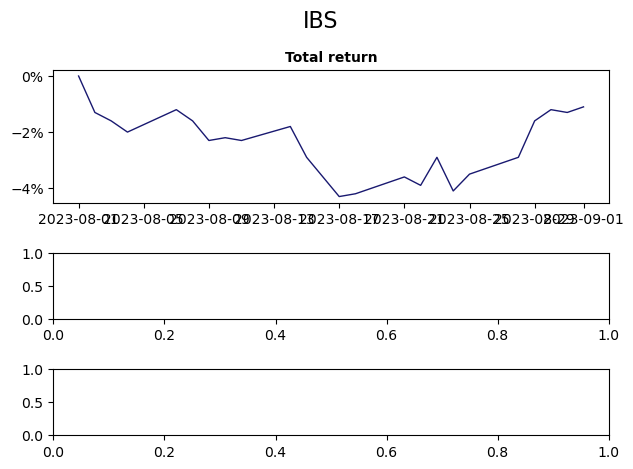

In [4]:
from event import OrderEvent
from strategy import Strategy
from backtest import Backtest
from datetime import date
from data_handler import HistoricalPolygonDataHandler
from broker import SimulatedBroker
from portfolio import StandardPortfolio


class BuyAndHoldStrategy(Strategy):
    # Buy and hold stocks in equal weight, sell everything at the end.

    def __init__(self, events, data_handler, portfolio, symbol_list=["SPY"]):
        self.events = events
        self.data_handler = data_handler  # To retrieve the data
        self.portfolio = portfolio  # To retrieve portfolio stats (equity, cash)

        self.symbol_list = symbol_list

        for symbol in self.symbol_list:
            self.data_handler.load_data(
                symbol,
                start_date=date(2023, 1, 1),
                end_date=date(2023, 9, 1),
                timeframe="daily",
                extended_hours=False,
            )

        self.in_market = False

    def calculate_signals(self):
        if not self.in_market:
            current_cash = self.portfolio.current_cash
            cash_per_symbol = current_cash / len(self.symbol_list)

            for symbol in self.symbol_list:
                latest_bar = self.data_handler.get_latest_bars(symbol, N=1)
                # There may be no data at all if the start/end dates of the loaded data do not align with the clock. However it is intentional that this is a possibility.
                if latest_bar.empty:
                    return
                last_close = latest_bar.iloc[-1]["close"]
                stocks_to_buy = int(cash_per_symbol / last_close)  # int = round down
                order = OrderEvent(
                    self.data_handler.current_time,
                    symbol,
                    side="BUY",
                    quantity=stocks_to_buy,
                )
                self.events.put(order)

            self.in_market = True

    def on_backtest_end(self):
        # Liquidate everything
        for symbol, position in self.portfolio.current_positions.items():
            if position != 0:
                action = "SELL" if position > 0 else "BUY"
                order = OrderEvent(
                    self.data_handler.current_time,
                    symbol,
                    side=action,
                    quantity=position,
                )
                self.events.put(order)

    def on_market_close(self):
        pass


backtest = Backtest(
    name="HODL",
    initial_capital=10000,
    start_date=date(2023, 1, 1),
    end_date=date(2023, 9, 1),
    timeframe="daily",
    extended_hours=False,
    strategy=BuyAndHoldStrategy,
    data_handler=HistoricalPolygonDataHandler,
    broker=SimulatedBroker,
    portfolio=StandardPortfolio,
)

backtest.run()
